In [1]:
import torch
import torch.nn as nn
from torch_geometric.data import Batch, Data

import numpy as np
import matplotlib.pyplot as plt

from layers.ect import EctLayer
from layers.config import EctConfig


from datasets.mnist import MnistDataModule 
from datasets.config import MnistDataModuleConfig

from pytranskit.optrans.continuous.cdt import CDT


dataset = MnistDataModule(MnistDataModuleConfig())



c:\Users\Ernst\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
NUM_PTS = 100
DEVICE = 'cuda:0'
NUM_THETAS = 64

V = torch.vstack(
    [
        torch.sin(torch.linspace(0, 2 * torch.pi, NUM_THETAS,device=DEVICE)),
        torch.cos(torch.linspace(0, 2 * torch.pi, NUM_THETAS,device=DEVICE)),
    ]
)


CONFIG = EctConfig(num_thetas=NUM_THETAS,bump_steps=NUM_THETAS,normalized=True,device=DEVICE)


In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = EctLayer(config = CONFIG,v=V)
        self.num_pts = NUM_PTS
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(NUM_THETAS**2,512), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(512,512), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(512,512), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(512, 2*NUM_PTS) 
        )

    def forward(self, batch):
        _batch = batch.clone()
        _batch.ect = self.layer(_batch)
        _batch.x = self.encoder(_batch.ect).view(-1,2) 
        _batch.batch = torch.arange(batch.batch.max().item()+1,device=DEVICE).repeat_interleave(NUM_PTS)
        decoded = self.layer(_batch) 
        return decoded, _batch

In [4]:
model = Autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
ectlayer = EctLayer(config = CONFIG, v=V)


In [5]:


# Point to training loop video
num_epochs = 3
for epoch in range(num_epochs):
    for batch in dataset.train_dataloader():
        batch = batch.to(DEVICE)
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon, _ = model(batch)
        batch_ect = ectlayer(batch) 
        loss = criterion(recon, batch_ect)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.6f}')

Epoch:1, Loss:0.000224
Epoch:2, Loss:0.000192
Epoch:3, Loss:0.000183


In [6]:
for test_batch in dataset.test_dataloader():
    break

recon_batch, internal_batch = model(test_batch.to(DEVICE))


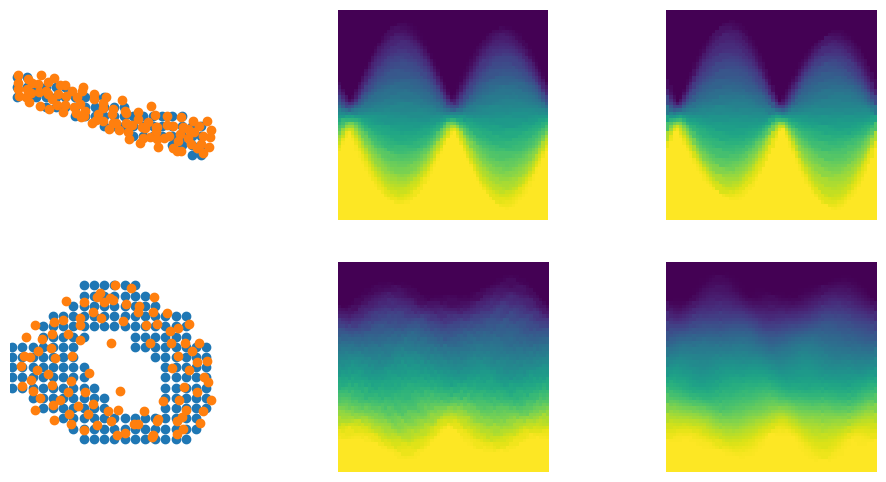

In [7]:
fig, axes = plt.subplots(2,3,figsize=(12,6))

for plt_idx,idx in enumerate([2,3]):
    pred = internal_batch.x[NUM_PTS*idx:NUM_PTS*idx+NUM_PTS].cpu().detach().numpy()
    points = test_batch[idx].x.cpu().detach().numpy()

    # fig, axes = plt.subplots(nrows=2, ncols=2)
    # fig.suptitle(f"{test_batch[idx].y.item()}", fontsize=20)

    # Plot the point clouds
    ax = axes[plt_idx,0]
    ax.axis("off")
    ax.scatter(points[:,0],points[:,1])
    ax.scatter(pred[:,0],pred[:,1])
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_aspect(1)

    # Plot the reconstructed ect
    ax = axes[plt_idx,1]
    ax.axis("off")
    ax.imshow(recon_batch[idx].cpu().squeeze().detach().numpy())

    # Plot the ect of the original
    ax = axes[plt_idx,2]
    ax.axis("off")
    ax.imshow(internal_batch.ect[idx].cpu().squeeze().detach().numpy())


# Interpolation

In [8]:
def cdt_interpolation(ect_start, ect_end,steps=100):
    ect_start = ect_start.cpu().squeeze().detach().numpy()
    ect_end = ect_end.cpu().squeeze().detach().numpy()
    N=NUM_THETAS
    x0 = np.linspace(0, 1, N)
    I0= np.ones(x0.size)
    x=np.linspace(0, 2, N)
    num_thetas = NUM_THETAS
    ect = np.zeros((num_thetas,num_thetas))
    I1 = abs(ect_start) + 1e-7
    I2 = abs(ect_end) + 1e-7

    I1 = I1/I1.sum(axis=0)
    I2 = I2/I2.sum(axis=0)
    
    taus = np.linspace(0,1,steps)
    cdt1 = CDT()
    inter = []

    for tau in taus: 
        for idx in range(num_thetas):
            # Compute the forward transform
            I1_hat, _, _ = cdt1.forward(x0, I0, x, I1[:,idx], rm_edge=False)
            I2_hat, _, _ = cdt1.forward(x0, I0, x, I2[:,idx], rm_edge=False)


            I_hat = ( tau ) * I1_hat + ( 1 - tau ) * I2_hat  
            I_recon = cdt1.inverse(I_hat, I0, x)

            ect[:,idx] = I_recon
            
        inter.append(ect)
        ect = np.zeros((num_thetas,num_thetas))
    return torch.tensor(np.stack(inter).cumsum(axis=1),dtype=torch.float,device=DEVICE)


def linear_interpolation(ect_start, ect_end,steps=100):
    taus = torch.linspace(0,2,steps=100,device=DEVICE).unsqueeze(1).unsqueeze(1)
    return taus * ect_start.unsqueeze(0).repeat(100,1,1) + (1-taus) *  ect_end.unsqueeze(0).repeat(100,1,1)
    



derlayer = EctLayer(config = EctConfig(num_thetas=NUM_THETAS,bump_steps=NUM_THETAS,device=DEVICE,ect_type="points_derivative",normalized=True),v=V)
ect_batch = derlayer(test_batch)

ect_start = ect_batch[0]
ect_end = ect_batch[2]

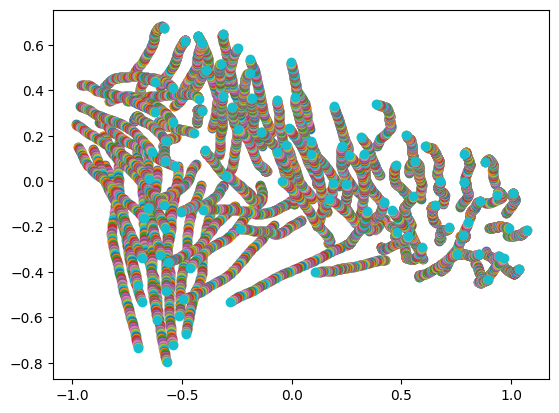

In [9]:
interp = cdt_interpolation(ect_start,ect_end)

# batch = Batch.from_data_list([Data(x=el.squeeze()) for el in interp])
for idx in range(100):
    pts = model.encoder(interp[idx].view(1,NUM_THETAS,NUM_THETAS)).view(-1,2).cpu().detach().numpy()
    plt.scatter(pts[:100,0],pts[:100,1])


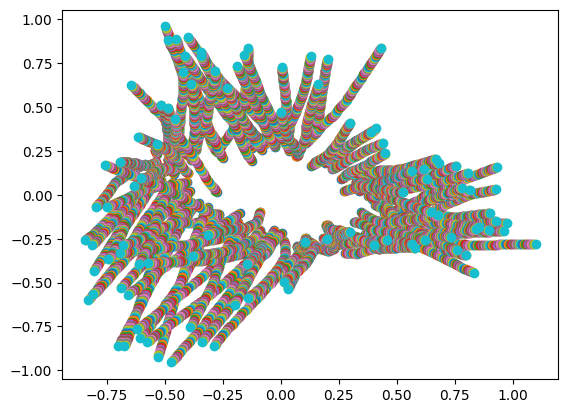

In [53]:
interp = linear_interpolation(ect_start,ect_end)

# batch = Batch.from_data_list([Data(x=el.squeeze()) for el in interp])
for idx in range(100):
    pts = model.encoder(interp[idx].view(1,NUM_THETAS,NUM_THETAS)).view(-1,2).cpu().detach().numpy()
    plt.scatter(pts[:100,0],pts[:100,1])


In [45]:
test_batch = Batch.from_data_list(
    [
        Data(x=torch.tensor([[0.4,0.7], [-.7,.3]])),
        Data(x=torch.tensor([[-0.2,0.2], [.7,.3]]))
    ]
).to(DEVICE)

res = ectlayer(test_batch)

interp = linear_interpolation(res[0],res[1].squeeze())


for idx, img in enumerate(interp): 
    plt.imsave(f"./ect/{idx}.jpg",img.cpu().squeeze())

import imageio
images = []
for idx in range(100):
    images.append(imageio.imread(f"./ect/{idx}.jpg"))
imageio.mimsave('movie_mnist_cdt.gif', images)


# # batch = Batch.from_data_list([Data(x=el.squeeze()) for el in interp])
# for idx in range(100):
#     pts = model.encoder(interp[idx].view(1,NUM_THETAS,NUM_THETAS)).view(-1,2).cpu().detach().numpy()
#     plt.scatter(pts[:100,0],pts[:100,1])

# fig, ax = plt.subplots(1,1)
# pts = test_batch.x.numpy()
# ax.scatter(pts[:,0],pts[:,1])
# ax.set_xlim([-1,1])
# ax.set_ylim([-1,1])

C:\Users\Ernst\AppData\Local\Temp\ipykernel_3572\186684484.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f"./ect/{idx}.jpg"))


In [27]:

# for idx in range(100):
#     # cent = internal_batch.centers[idx]
    
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

#     pts = model.encoder(interp[idx].view(1,NUM_THETAS,NUM_THETAS)).view(-1,2).cpu().detach().numpy()

#     ax = axes[0]
#     ax.axis("off")
#     ax.scatter(pts[:,0],pts[:,1])

#     ax = axes[1]
#     ax.axis("off")
#     ax.imshow(interp[idx].cpu().squeeze().detach().numpy())

#     fig.savefig(f"./imgs/{idx}.jpg")